# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '13'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedsnow"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2150090)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 17:34:22 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedsnow.values
    n_s  = xr.open_dataset(fname).n_rimedsnow.values
    r_s  = xr.open_dataset(fname).rime_rimedsnow.values
    v_s  = xr.open_dataset(fname).rvol_rimedsnow.values
    liq_s = xr.open_dataset(fname).liq_rimedsnow.values
    # sedimentation velocities
    vel_num  = xr.open_dataset(fname).rimedsnow_vel_num.values
    vel_liq  = xr.open_dataset(fname).rimedsnow_vel_liq.values
    vel_mass = xr.open_dataset(fname).rimedsnow_vel_mass.values
    vel_rime = xr.open_dataset(fname).rimedsnow_vel_rime.values
    vel_liq  = np.where(vel_liq < vel_mass,vel_mass,vel_liq)  
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    z_min = 1e-20
    p_min = 1e-20
    # use liquid water fraction (no log transform for this)
    liq_s = np.where(q_s>q_min,liq_s/q_s,np.nan)  
    liq_s = np.where(liq_s<0,np.nan,liq_s)  
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*n_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    vel_num  = np.log(vel_num,  where=vel_num>p_min,  out=np.nan*vel_num)    
    vel_mass = np.log(vel_mass, where=vel_mass>p_min, out=np.nan*vel_mass)
    vel_rime = np.log(vel_rime, where=vel_rime>p_min, out=np.nan*vel_rime)
    vel_liq  = np.log(vel_liq,  where=vel_liq>p_min,  out=np.nan*vel_liq)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, n_s, r_s, v_s, liq_s, rho, vel_num, vel_mass, vel_rime, vel_liq ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'n_s', 'r_s', 'v_s', 'liq_s', 'rho', 'vel_num', 'vel_mass', 'vel_rime', 'vel_liq' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

In [8]:
df.describe()

q_s           n_s           r_s           v_s         liq_s  \
count  2.145029e+06  2.145029e+06  2.145029e+06  2.145029e+06  2.145029e+06   
mean  -5.637161e+00  2.985831e+00 -6.659798e+00 -1.265974e+01  1.810391e-01   
std    1.616358e+00  4.769517e+00  2.150824e+00  2.053658e+00  2.591522e-01   
min   -2.237666e+01 -1.449861e+01 -2.261646e+01 -2.763062e+01  0.000000e+00   
25%   -6.046216e+00  8.472407e-01 -7.369997e+00 -1.318882e+01  0.000000e+00   
50%   -5.353724e+00  4.273968e+00 -6.281763e+00 -1.224900e+01  4.834032e-02   
75%   -4.790392e+00  5.682525e+00 -5.328076e+00 -1.149883e+01  2.616982e-01   
max   -2.958918e+00  1.430654e+01 -3.173640e+00 -8.316296e+00  9.998519e-01   

                rho       vel_num      vel_mass      vel_rime       vel_liq  
count  2.145029e+06  2.145029e+06  2.145029e+06  2.145029e+06  2.145029e+06  
mean   1.105299e+00  9.896457e-01  1.115573e+00  1.113591e+00  1.149389e+00  
std    1.103007e-01  6.578946e-01  5.184605e-01  4.986501e-01  5.225140e-01  
min    7.110000e-01 -2.299590e+00 -2.299590e+00 -2.299590e+00 -2.299590e+00  
25%    1.044000e+00  5.492768e-01  7.414610e-01  7.485819e-01  7.668623e-01  
50%    1.129000e+00  9.906558e-01  1.041689e+00  1.046968e+00  1.092259e+00  
75%    1.189000e+00  1.491330e+00  1.470176e+00  1.449269e+00  1.520825e+00  
max    1.289000e+00  3.460095e+00  4.823502e+00  3.460095e+00  8.593783e+00

### Split in training, testing and validation with 70/15/15 rule

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s       n_s        r_s        v_s         liq_s    rho   vel_num  \
0 -8.190158  8.328547 -12.067076 -17.079985  4.633522e-08  1.038 -0.460291   
1 -8.145182  8.327775 -10.987842 -16.001913  0.000000e+00  1.039 -0.444726   
2 -8.104156  8.323147 -10.500016 -15.516023  5.198491e-06  1.040 -0.428785   
3 -8.066754  8.318206 -10.189570 -15.207219  0.000000e+00  1.041 -0.414304   
7 -7.948250  8.300231  -9.548180 -14.572386  0.000000e+00  1.046 -0.367303   

   vel_mass  vel_rime   vel_liq  
0 -0.006924  0.033435  0.291923  
1  0.016857  0.055435  0.016857  
2  0.037296  0.076035  0.338613  
3  0.056380  0.093490  0.056380  
7  0.114221  0.147558  0.114221

In [11]:
dataset_train.describe()

q_s           n_s           r_s           v_s         liq_s  \
count  1.501759e+06  1.501759e+06  1.501759e+06  1.501759e+06  1.501759e+06   
mean  -5.639343e+00  2.986602e+00 -6.661956e+00 -1.266200e+01  1.812159e-01   
std    1.621915e+00  4.768084e+00  2.153781e+00  2.057231e+00  2.593015e-01   
min   -2.237666e+01 -1.449861e+01 -2.261646e+01 -2.763062e+01  0.000000e+00   
25%   -6.047146e+00  8.509198e-01 -7.370879e+00 -1.319059e+01  0.000000e+00   
50%   -5.354761e+00  4.273048e+00 -6.283476e+00 -1.224950e+01  4.849377e-02   
75%   -4.790910e+00  5.683886e+00 -5.328921e+00 -1.150031e+01  2.623344e-01   
max   -2.958918e+00  1.430654e+01 -3.173640e+00 -8.316296e+00  9.998436e-01   

                rho       vel_num      vel_mass      vel_rime       vel_liq  
count  1.501759e+06  1.501759e+06  1.501759e+06  1.501759e+06  1.501759e+06  
mean   1.105328e+00  9.896967e-01  1.115592e+00  1.113599e+00  1.149348e+00  
std    1.102780e-01  6.581431e-01  5.185758e-01  4.987873e-01  5.225824e-01  
min    7.120000e-01 -2.299590e+00 -2.299590e+00 -2.299590e+00 -2.299590e+00  
25%    1.044000e+00  5.492768e-01  7.414610e-01  7.485819e-01  7.668623e-01  
50%    1.129000e+00  9.906558e-01  1.041689e+00  1.046968e+00  1.092259e+00  
75%    1.189000e+00  1.492005e+00  1.470865e+00  1.449739e+00  1.521044e+00  
max    1.289000e+00  3.460095e+00  4.823502e+00  3.460095e+00  8.593783e+00

In [12]:
dataset_test.describe()

q_s            n_s            r_s            v_s  \
count  321639.000000  321639.000000  321639.000000  321639.000000   
mean       -5.632388       2.973914      -6.657910     -12.657676   
std         1.602365       4.785499       2.148402       2.049634   
min       -22.215944     -14.498609     -22.570009     -27.628923   
25%        -6.044148       0.831343      -7.369077     -13.187062   
50%        -5.350748       4.271947      -6.280267     -12.249398   
75%        -4.790247       5.675366      -5.329633     -11.496954   
max        -3.177278      14.200161      -3.328217      -8.738650   

               liq_s            rho        vel_num       vel_mass  \
count  321639.000000  321639.000000  321639.000000  321639.000000   
mean        0.180878       1.105507       0.989746       1.116052   
std         0.259069       0.110135       0.657636       0.517885   
min         0.000000       0.712000      -2.201835      -2.201835   
25%         0.000000       1.044000       0.550431       0.741937   
50%         0.048427       1.129000       0.989169       1.041689   
75%         0.261152       1.189000       1.491780       1.469486   
max         0.999837       1.288000       3.460095       4.108740   

            vel_rime        vel_liq  
count  321639.000000  321639.000000  
mean        1.114028       1.149946  
std         0.497972       0.521846  
min        -2.201835      -2.201835  
25%         0.748582       0.767791  
50%         1.046968       1.092594  
75%         1.448330       1.519732  
max         3.460095       7.939515

In [13]:
dataset_val.describe()

q_s            n_s            r_s            v_s  \
count  321631.000000  321631.000000  321631.000000  321631.000000   
mean       -5.631747       2.994155      -6.651634     -12.651301   
std         1.604238       4.760179       2.139381       2.040923   
min       -22.211637     -14.498609     -22.540281     -27.611219   
25%        -6.043474       0.845911      -7.367112     -13.184133   
50%        -5.351528       4.280243      -6.275527     -12.246082   
75%        -4.788462       5.683937      -5.322334     -11.493907   
max        -3.125477      14.277356      -3.405025      -8.925537   

               liq_s            rho        vel_num       vel_mass  \
count  321631.000000  321631.000000  321631.000000  321631.000000   
mean        0.180375       1.104958       0.989307       1.115004   
std         0.258537       0.110571       0.656993       0.518498   
min         0.000000       0.711000      -2.268184      -2.268184   
25%         0.000000       1.043000       0.550431       0.741461   
50%         0.047587       1.128000       0.990656       1.041336   
75%         0.259632       1.189000       1.488625       1.468335   
max         0.999852       1.289000       2.708717       3.886500   

            vel_rime        vel_liq  
count  321631.000000  321631.000000  
mean        1.113121       1.149027  
std         0.498688       0.522864  
min        -2.268184      -2.268184  
25%         0.748582       0.767327  
50%         1.046968       1.092259  
75%         1.447860       1.519951  
max         2.708717       5.303305

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s           n_s           r_s           v_s         liq_s  \
count  1.500619e+06  1.500619e+06  1.500619e+06  1.500619e+06  1.500619e+06   
mean  -5.627900e+00  2.993557e+00 -6.651213e+00 -1.265119e+01  1.813442e-01   
std    1.568375e+00  4.762320e+00  2.118963e+00  2.020214e+00  2.593538e-01   
min   -1.999906e+01 -1.449861e+01 -2.261646e+01 -2.762832e+01  0.000000e+00   
25%   -6.045076e+00  8.649132e-01 -7.367397e+00 -1.318744e+01  0.000000e+00   
50%   -5.353894e+00  4.275402e+00 -6.282031e+00 -1.224835e+01  4.875052e-02   
75%   -4.790368e+00  5.686246e+00 -5.328158e+00 -1.149961e+01  2.626711e-01   
max   -2.958918e+00  1.430654e+01 -3.173640e+00 -8.316296e+00  9.998436e-01   

                rho       vel_num      vel_mass      vel_rime       vel_liq  
count  1.500619e+06  1.500619e+06  1.500619e+06  1.500619e+06  1.500619e+06  
mean   1.105349e+00  9.900579e-01  1.115833e+00  1.113827e+00  1.149611e+00  
std    1.103030e-01  6.578898e-01  5.183321e-01  4.985366e-01  5.223279e-01  
min    7.120000e-01 -2.299590e+00 -2.299590e+00 -2.299590e+00 -2.299590e+00  
25%    1.044000e+00  5.492768e-01  7.419373e-01  7.485819e-01  7.668623e-01  
50%    1.129000e+00  9.910271e-01  1.041689e+00  1.046968e+00  1.092594e+00  
75%    1.189000e+00  1.492005e+00  1.470865e+00  1.449739e+00  1.521044e+00  
max    1.289000e+00  3.460095e+00  4.823502e+00  3.460095e+00  8.593783e+00

In [17]:
dataset_test.describe()

q_s            n_s            r_s            v_s  \
count  321431.000000  321431.000000  321431.000000  321431.000000   
mean       -5.622636       2.979625      -6.648758     -12.648477   
std         1.556271       4.781076       2.118709       2.018076   
min       -19.994413     -14.498609     -22.570009     -27.628923   
25%        -6.042063       0.842537      -7.366123     -13.184238   
50%        -5.350116       4.274121      -6.278827     -12.248458   
75%        -4.789886       5.677336      -5.328983     -11.496462   
max        -3.177278      14.200161      -3.328217      -8.738650   

               liq_s            rho        vel_num       vel_mass  \
count  321431.000000  321431.000000  321431.000000  321431.000000   
mean        0.180990       1.105525       0.990090       1.116291   
std         0.259113       0.110156       0.657417       0.517674   
min         0.000000       0.712000      -2.201835      -2.201835   
25%         0.000000       1.044000       0.550431       0.742413   
50%         0.048699       1.129000       0.989541       1.041689   
75%         0.261422       1.189000       1.491780       1.469486   
max         0.999837       1.288000       3.460095       4.108740   

            vel_rime        vel_liq  
count  321431.000000  321431.000000  
mean        1.114257       1.150201  
std         0.497756       0.521626  
min        -2.201835      -2.201835  
25%         0.749055       0.767791  
50%         1.046968       1.092594  
75%         1.448330       1.519732  
max         3.460095       7.939515

### Pairplot

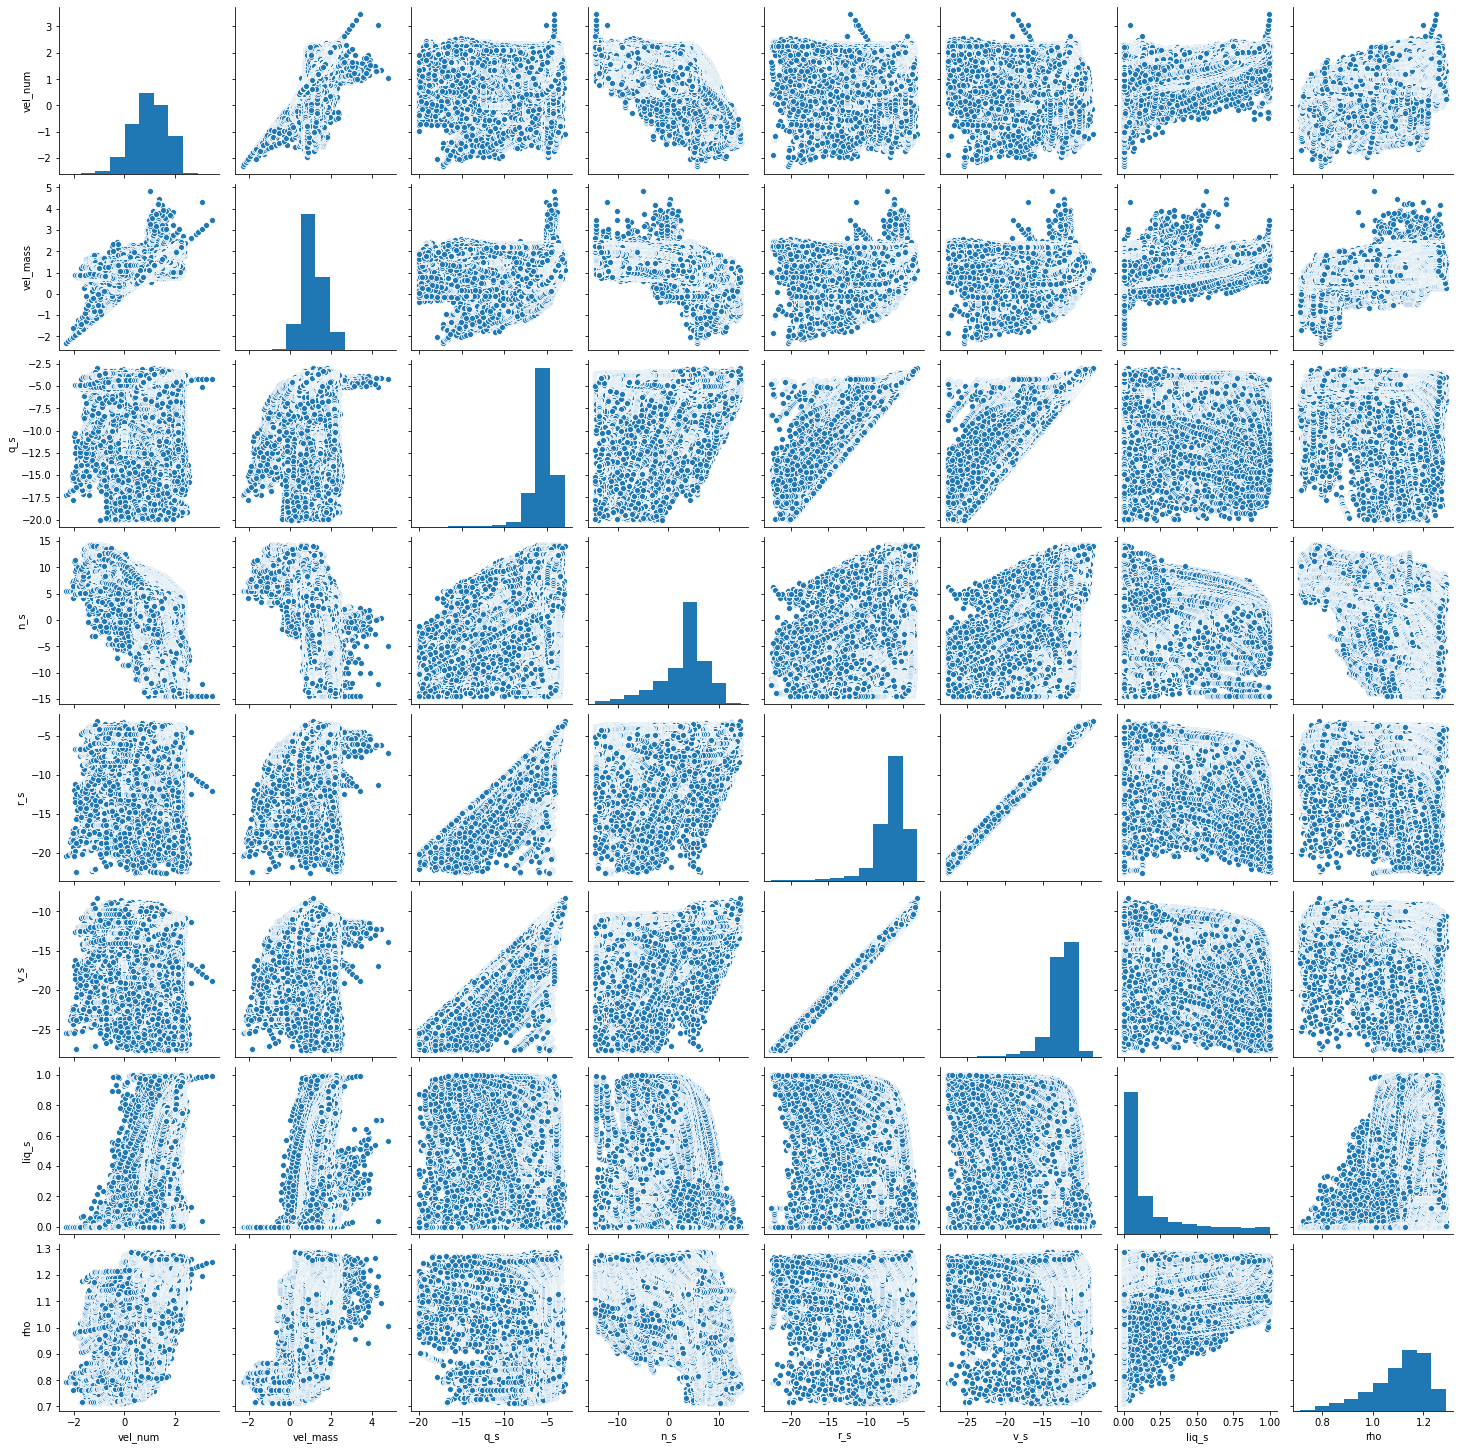

In [18]:
sns.pairplot(dataset_train[["vel_num","vel_mass","q_s","n_s","r_s","v_s","liq_s","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()
train_dataset5 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()
test_dataset5 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()
val_dataset5 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['liq_s','rho'], axis=1)
train_dataset2 = train_dataset2.drop(['liq_s'], axis=1)
#train_dataset3 = train_dataset3.drop(['ssi'], axis=1)
#train_dataset4 = train_dataset4.drop(['zi'], axis=1)
#train_dataset5 = train_dataset5.drop(['qs'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['liq_s','rho'], axis=1)
test_dataset2 = test_dataset2.drop(['liq_s'], axis=1)
#test_dataset3 = test_dataset3.drop(['ssi'], axis=1)
#test_dataset4 = test_dataset4.drop(['zi'], axis=1)
#test_dataset5 = test_dataset5.drop(['qs'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['liq_s','rho'], axis=1)
val_dataset2 = val_dataset2.drop(['liq_s'], axis=1)
#val_dataset3 = val_dataset3.drop(['ssi'], axis=1)
#val_dataset4 = val_dataset4.drop(['zi'], axis=1)
#val_dataset5 = val_dataset5.drop(['qs'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("vel_num")
train_stats1.pop("vel_mass")
train_stats1.pop("vel_rime")
train_stats1.pop("vel_liq")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s  1500619.0  -5.627900  1.568375 -19.999056  -6.045076  -5.353894   
n_s  1500619.0   2.993557  4.762320 -14.498609   0.864913   4.275402   
r_s  1500619.0  -6.651213  2.118963 -22.616461  -7.367397  -6.282031   
v_s  1500619.0 -12.651185  2.020214 -27.628325 -13.187435 -12.248354   

           75%        max  
q_s  -4.790368  -2.958918  
n_s   5.686246  14.306541  
r_s  -5.328158  -3.173640  
v_s -11.499615  -8.316296

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("vel_num")
train_stats2.pop("vel_mass")
train_stats2.pop("vel_rime")
train_stats2.pop("vel_liq")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%  \
q_s  1500619.0  -5.627900  1.568375 -19.999056  -6.045076  -5.353894   
n_s  1500619.0   2.993557  4.762320 -14.498609   0.864913   4.275402   
r_s  1500619.0  -6.651213  2.118963 -22.616461  -7.367397  -6.282031   
v_s  1500619.0 -12.651185  2.020214 -27.628325 -13.187435 -12.248354   
rho  1500619.0   1.105349  0.110303   0.712000   1.044000   1.129000   

           75%        max  
q_s  -4.790368  -2.958918  
n_s   5.686246  14.306541  
r_s  -5.328158  -3.173640  
v_s -11.499615  -8.316296  
rho   1.189000   1.289000

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("vel_num")
train_stats3.pop("vel_mass")
train_stats3.pop("vel_rime")
train_stats3.pop("vel_liq")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%  \
q_s    1500619.0  -5.627900  1.568375 -19.999056  -6.045076  -5.353894   
n_s    1500619.0   2.993557  4.762320 -14.498609   0.864913   4.275402   
r_s    1500619.0  -6.651213  2.118963 -22.616461  -7.367397  -6.282031   
v_s    1500619.0 -12.651185  2.020214 -27.628325 -13.187435 -12.248354   
liq_s  1500619.0   0.181344  0.259354   0.000000   0.000000   0.048751   
rho    1500619.0   1.105349  0.110303   0.712000   1.044000   1.129000   

             75%        max  
q_s    -4.790368  -2.958918  
n_s     5.686246  14.306541  
r_s    -5.328158  -3.173640  
v_s   -11.499615  -8.316296  
liq_s   0.262671   0.999844  
rho     1.189000   1.289000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = ['vel_num','vel_mass','vel_rime','vel_liq']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

vel_num      vel_mass      vel_rime       vel_liq
count  1.500619e+06  1.500619e+06  1.500619e+06  1.500619e+06
mean   9.900579e-01  1.115833e+00  1.113827e+00  1.149611e+00
std    6.578898e-01  5.183321e-01  4.985366e-01  5.223279e-01
min   -2.299590e+00 -2.299590e+00 -2.299590e+00 -2.299590e+00
25%    5.492768e-01  7.419373e-01  7.485819e-01  7.668623e-01
50%    9.910271e-01  1.041689e+00  1.046968e+00  1.092594e+00
75%    1.492005e+00  1.470865e+00  1.449739e+00  1.521044e+00
max    3.460095e+00  4.823502e+00  3.460095e+00  8.593783e+00

In [32]:
train_dataset1.describe()

q_s           n_s           r_s           v_s
count  1.500619e+06  1.500619e+06  1.500619e+06  1.500619e+06
mean  -5.627900e+00  2.993557e+00 -6.651213e+00 -1.265119e+01
std    1.568375e+00  4.762320e+00  2.118963e+00  2.020214e+00
min   -1.999906e+01 -1.449861e+01 -2.261646e+01 -2.762832e+01
25%   -6.045076e+00  8.649132e-01 -7.367397e+00 -1.318744e+01
50%   -5.353894e+00  4.275402e+00 -6.282031e+00 -1.224835e+01
75%   -4.790368e+00  5.686246e+00 -5.328158e+00 -1.149961e+01
max   -2.958918e+00  1.430654e+01 -3.173640e+00 -8.316296e+00

In [33]:
train_dataset2.describe()

q_s           n_s           r_s           v_s           rho
count  1.500619e+06  1.500619e+06  1.500619e+06  1.500619e+06  1.500619e+06
mean  -5.627900e+00  2.993557e+00 -6.651213e+00 -1.265119e+01  1.105349e+00
std    1.568375e+00  4.762320e+00  2.118963e+00  2.020214e+00  1.103030e-01
min   -1.999906e+01 -1.449861e+01 -2.261646e+01 -2.762832e+01  7.120000e-01
25%   -6.045076e+00  8.649132e-01 -7.367397e+00 -1.318744e+01  1.044000e+00
50%   -5.353894e+00  4.275402e+00 -6.282031e+00 -1.224835e+01  1.129000e+00
75%   -4.790368e+00  5.686246e+00 -5.328158e+00 -1.149961e+01  1.189000e+00
max   -2.958918e+00  1.430654e+01 -3.173640e+00 -8.316296e+00  1.289000e+00

In [34]:
train_dataset3.describe()

q_s           n_s           r_s           v_s         liq_s  \
count  1.500619e+06  1.500619e+06  1.500619e+06  1.500619e+06  1.500619e+06   
mean  -5.627900e+00  2.993557e+00 -6.651213e+00 -1.265119e+01  1.813442e-01   
std    1.568375e+00  4.762320e+00  2.118963e+00  2.020214e+00  2.593538e-01   
min   -1.999906e+01 -1.449861e+01 -2.261646e+01 -2.762832e+01  0.000000e+00   
25%   -6.045076e+00  8.649132e-01 -7.367397e+00 -1.318744e+01  0.000000e+00   
50%   -5.353894e+00  4.275402e+00 -6.282031e+00 -1.224835e+01  4.875052e-02   
75%   -4.790368e+00  5.686246e+00 -5.328158e+00 -1.149961e+01  2.626711e-01   
max   -2.958918e+00  1.430654e+01 -3.173640e+00 -8.316296e+00  9.998436e-01   

                rho  
count  1.500619e+06  
mean   1.105349e+00  
std    1.103030e-01  
min    7.120000e-01  
25%    1.044000e+00  
50%    1.129000e+00  
75%    1.189000e+00  
max    1.289000e+00

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s  1500619.0  4.169091e-07  1.0 -9.163090 -0.265993  0.174707  0.534012   
n_s  1500619.0 -1.374317e-07  1.0 -3.673035 -0.446976  0.269164  0.565415   
r_s  1500619.0  3.097371e-07  1.0 -7.534464 -0.337988  0.174228  0.624388   
v_s  1500619.0 -3.099958e-07  1.0 -7.413641 -0.265442  0.199400  0.570024   

          max  
q_s  1.701750  
n_s  2.375520  
r_s  1.641168  
v_s  2.145758

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_s  1500619.0  4.169091e-07  1.0 -9.163090 -0.265993  0.174707  0.534012   
n_s  1500619.0 -1.374317e-07  1.0 -3.673035 -0.446976  0.269164  0.565415   
r_s  1500619.0  3.097371e-07  1.0 -7.534464 -0.337988  0.174228  0.624388   
v_s  1500619.0 -3.099958e-07  1.0 -7.413641 -0.265442  0.199400  0.570024   
rho  1500619.0 -1.754993e-06  1.0 -3.566082 -0.556190  0.214414  0.758371   

          max  
q_s  1.701750  
n_s  2.375520  
r_s  1.641168  
v_s  2.145758  
rho  1.664965

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_s    1500619.0  4.169091e-07  1.0 -9.163090 -0.265993  0.174707  0.534012   
n_s    1500619.0 -1.374317e-07  1.0 -3.673035 -0.446976  0.269164  0.565415   
r_s    1500619.0  3.097371e-07  1.0 -7.534464 -0.337988  0.174228  0.624388   
v_s    1500619.0 -3.099958e-07  1.0 -7.413641 -0.265442  0.199400  0.570024   
liq_s  1500619.0 -5.353578e-08  1.0 -0.699215 -0.699215 -0.511246  0.313575   
rho    1500619.0 -1.754993e-06  1.0 -3.566082 -0.556190  0.214414  0.758371   

            max  
q_s    1.701750  
n_s    2.375520  
r_s    1.641168  
v_s    2.145758  
liq_s  3.155918  
rho    1.664965

### Normalize the labels

In [39]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count      mean       std      min       25%       50%  \
vel_num   1500619.0  0.990058  0.657890 -2.29959  0.549277  0.991027   
vel_mass  1500619.0  1.115833  0.518332 -2.29959  0.741937  1.041689   
vel_rime  1500619.0  1.113827  0.498537 -2.29959  0.748582  1.046968   
vel_liq   1500619.0  1.149611  0.522328 -2.29959  0.766862  1.092594   

               75%       max  
vel_num   1.492005  3.460095  
vel_mass  1.470865  4.823502  
vel_rime  1.449739  3.460095  
vel_liq   1.521044  8.593783

In [40]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [41]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [42]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(4,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 692
Trainable params: 692
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [44]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.67556864, -0.6655124 ,  0.00934175,  0.35393545],
       [-0.6819683 , -0.66664195,  0.0118852 ,  0.35750198],
       [-0.6855256 , -0.6671952 ,  0.01320919,  0.35937303],
       [-0.68802357, -0.66757107,  0.01410383,  0.360647  ],
       [-0.6937803 , -0.6684424 ,  0.01604986,  0.36345723],
       [-0.69467115, -0.66858196,  0.01633587,  0.3638752 ],
       [-0.69543767, -0.6687039 ,  0.01657763,  0.364231  ],
       [-0.696099  , -0.6688108 ,  0.01678303,  0.3645353 ],
       [-0.6971523 , -0.66898483,  0.01710406,  0.36501348],
       [-0.6975715 , -0.66905594,  0.01722905,  0.3652014 ]],
      dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [47]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [48]:
activ = "ReLU"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1990,  mae:0.3196,  mse:0.1990,  val_loss:0.1769,  val_mae:0.2966,  val_mse:0.1769,  
......................

Text(0, 0.5, 'MAE')

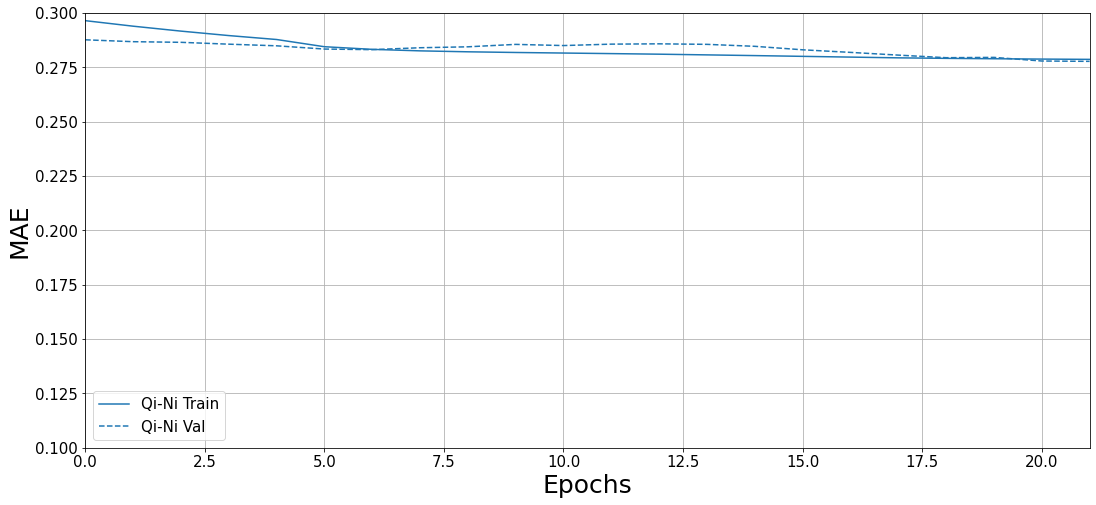

In [49]:
histories['qi-ni'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1,0.3])
plt.ylabel('MAE')

In [50]:
model2 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1600,  mae:0.2824,  mse:0.1600,  val_loss:0.1443,  val_mae:0.2686,  val_mse:0.1443,  
...............................

Text(0, 0.5, 'MAE')

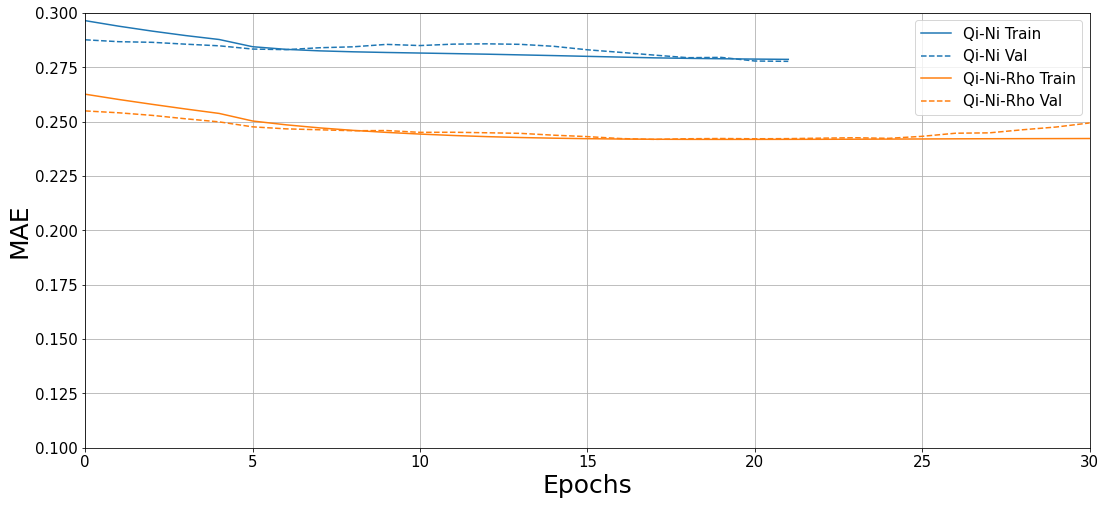

In [51]:
histories['qi-ni-rho'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.3])
plt.ylabel('MAE')

In [52]:
model3 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0423,  mae:0.1216,  mse:0.0423,  val_loss:0.0368,  val_mae:0.1186,  val_mse:0.0368,  
..........................

Text(0, 0.5, 'MAE')

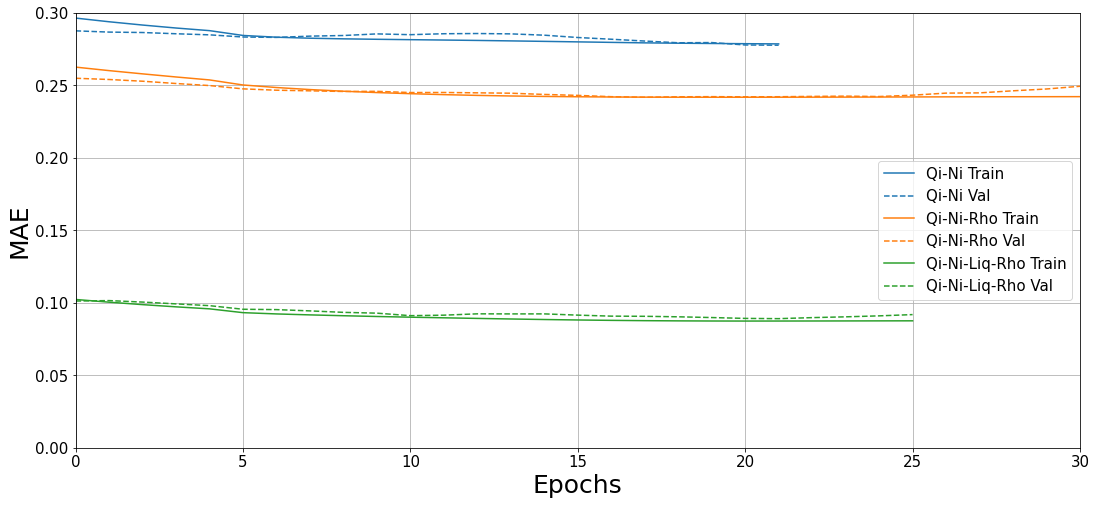

In [53]:
histories['qi-ni-liq-rho'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.3])
plt.ylabel('MAE')

In [54]:
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1644,  mae:0.2872,  mse:0.1644,  val_loss:0.1466,  val_mae:0.2711,  val_mse:0.1466,  
...................

Text(0, 0.5, 'MAE')

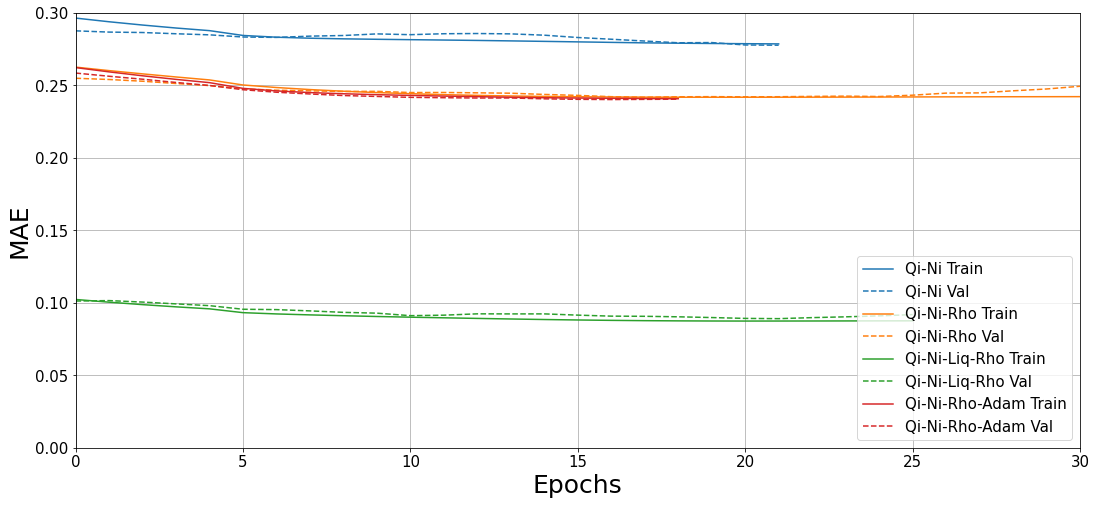

In [55]:
histories['qi-ni-rho-Adam'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.3])
plt.ylabel('MAE')

In [56]:
model5 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history5 = model5.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0395,  mae:0.1167,  mse:0.0395,  val_loss:0.0298,  val_mae:0.0944,  val_mse:0.0298,  
.................

Text(0, 0.5, 'MAE')

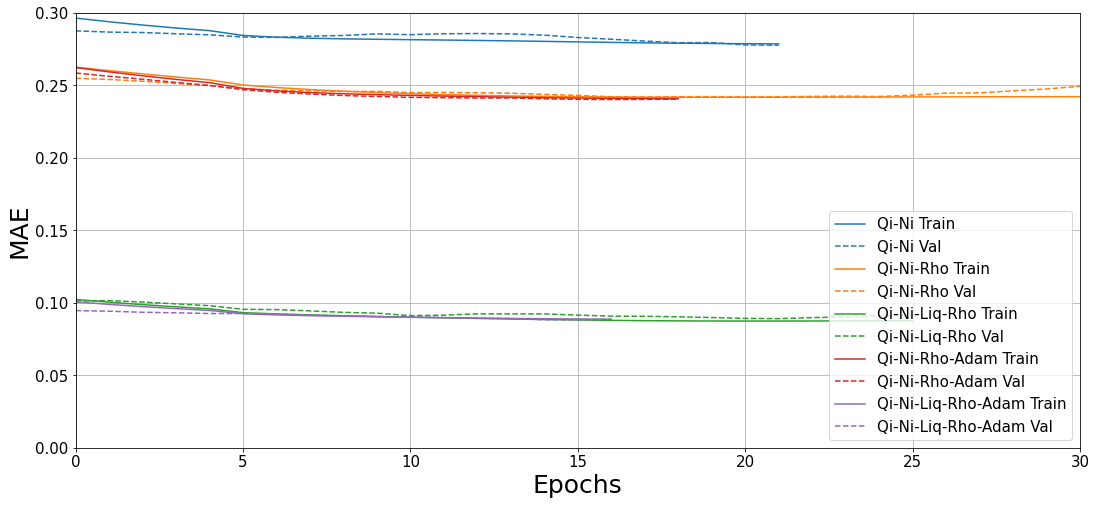

In [57]:
histories['qi-ni-liq-rho-Adam'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.3])
plt.ylabel('MAE')

In [58]:
nsize=32
activ = "ReLU_Adam"
model6 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history6 = model6.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1391,  mae:0.2573,  mse:0.1391,  val_loss:0.1255,  val_mae:0.2420,  val_mse:0.1255,  
..........................

Text(0, 0.5, 'MAE')

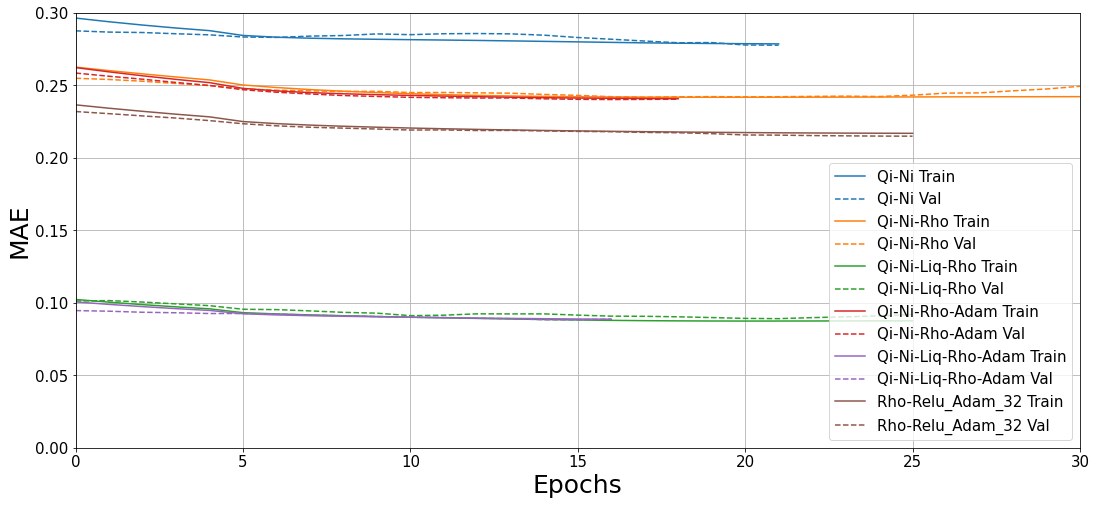

In [59]:
histories['rho-ReLU_Adam_32'] = early_history6

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.3])
plt.ylabel('MAE')

In [60]:
activ = "ReLU_Adam"
model7 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history7 = model7.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0331,  mae:0.1036,  mse:0.0331,  val_loss:0.0250,  val_mae:0.0839,  val_mse:0.0250,  
..........................

Text(0, 0.5, 'MAE')

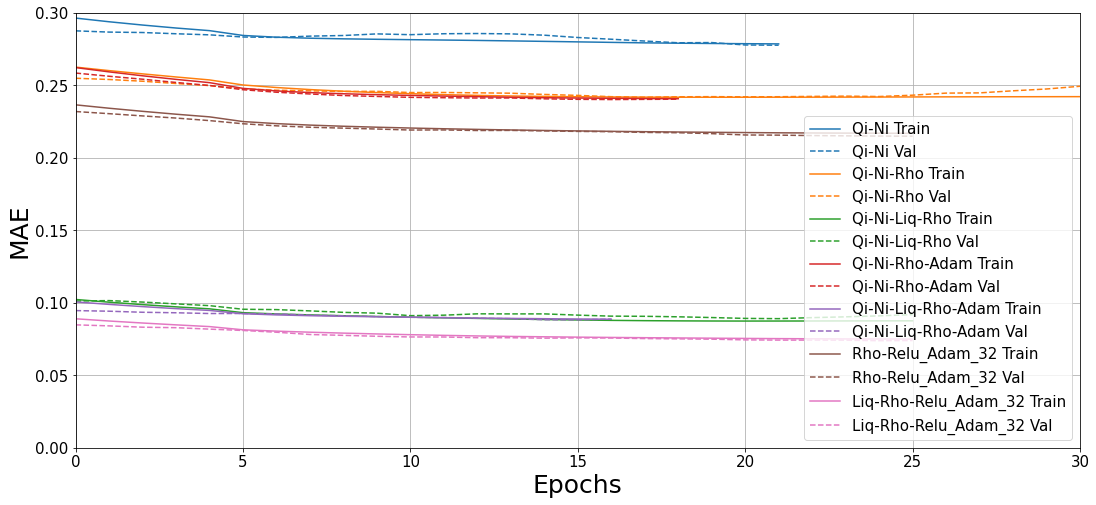

In [61]:
histories['liq-rho-ReLU_Adam_32'] = early_history7

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.00, 0.3])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

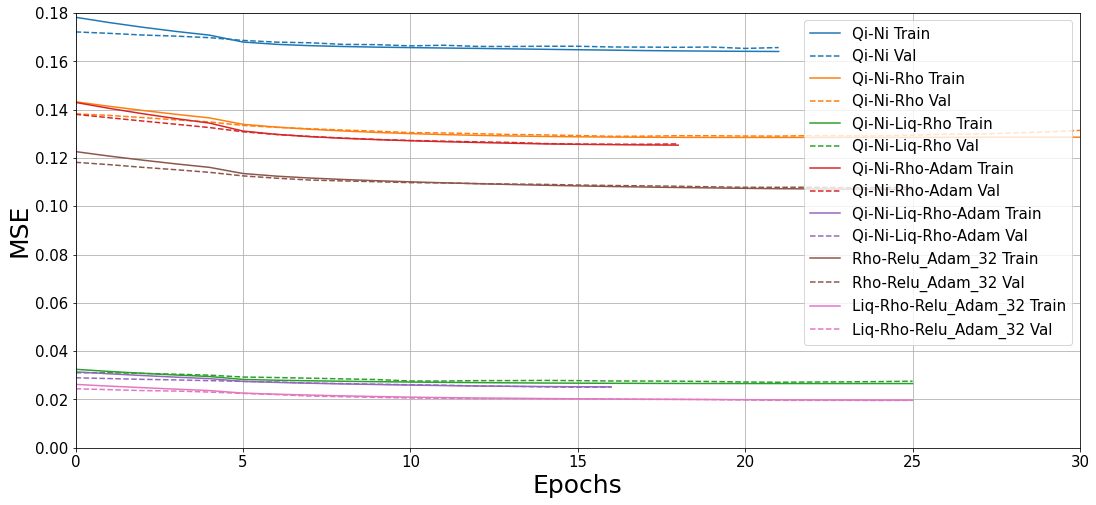

In [64]:

plotter.plot(histories, metric = "mse")
plt.ylim([0.0, 0.18])
plt.ylabel('MSE')

In [65]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

321431/321431 - 7s - loss: 0.1621 - mae: 0.2794 - mse: 0.1621
Testing set for model 1, Mean Abs Error:    0.27938


In [66]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

321431/321431 - 8s - loss: 0.1269 - mae: 0.2368 - mse: 0.1269
Testing set for model 2, Mean Abs Error:              0.23681


In [67]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

321431/321431 - 8s - loss: 0.0265 - mae: 0.0846 - mse: 0.0265
Testing set for model 3, Mean Abs Error:              0.08460


In [68]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

321431/321431 - 8s - loss: 0.1239 - mae: 0.2383 - mse: 0.1239
Testing set for model 4, Mean Abs Error:              0.23834


In [69]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

321431/321431 - 8s - loss: 0.0252 - mae: 0.0862 - mse: 0.0252
Testing set for model 5, Mean Abs Error:              0.08617


In [70]:
loss6, mae6, mse6 = model6.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 6, Mean Abs Error: {:20.5f}".format(mae6))

321431/321431 - 8s - loss: 0.1067 - mae: 0.2161 - mse: 0.1067
Testing set for model 6, Mean Abs Error:              0.21611


In [71]:
loss7, mae7, mse7 = model7.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 7, Mean Abs Error: {:20.5f}".format(mae7))

321431/321431 - 7s - loss: 0.0194 - mae: 0.0732 - mse: 0.0194
Testing set for model 7, Mean Abs Error:              0.07323


In [72]:
mae = [ mae1, mae2, mae3, mae4, mae5, mae6, mae7 ]
mae

[0.279381,
 0.23680632,
 0.08459715,
 0.23834112,
 0.08616849,
 0.21611199,
 0.07323322]

In [73]:
mse = [ mse1, mse2, mse3, mse4, mse5, mse6, mse7 ]
mse

[0.16205627,
 0.12685151,
 0.026472865,
 0.123858035,
 0.025232272,
 0.106665365,
 0.019358002]

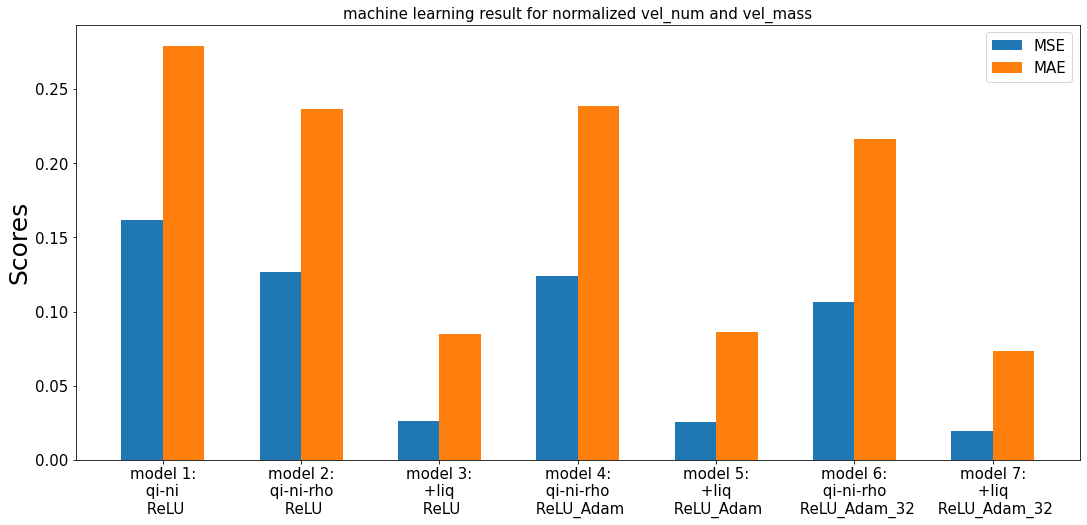

In [74]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1:\n qi-ni \n ReLU',
 'model 2:\n qi-ni-rho \n ReLU',
 'model 3:\n +liq \n ReLU',
 'model 4:\n qi-ni-rho \n ReLU_Adam',
 'model 5:\n +liq \n ReLU_Adam',
 'model 6:\n qi-ni-rho \n ReLU_Adam_32',
 'model 7:\n +liq \n ReLU_Adam_32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized vel_num and vel_mass')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [75]:
test_true_num  = np.exp(test_labels.pop('vel_num'))
test_true_mass = np.exp(test_labels.pop('vel_mass'))

In [76]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [77]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["vel_num", "vel_mass","vel_rime","vel_liq"])

In [78]:
p1.describe()

vel_num       vel_mass       vel_rime        vel_liq
count  321431.000000  321431.000000  321431.000000  321431.000000
mean       -0.004830       0.003990       0.005058       0.002018
std         0.888882       0.904205       0.890357       0.897511
min        -4.533704      -6.122937      -6.382844      -6.084613
25%        -0.465450      -0.613280      -0.603603      -0.602686
50%         0.008670      -0.129081      -0.124664      -0.116008
75%         0.601343       0.571481       0.556894       0.574041
max         2.528365       2.905594       2.927405       2.830223

In [79]:
train_labels_stats

count      mean       std      min       25%       50%  \
vel_num   1500619.0  0.990058  0.657890 -2.29959  0.549277  0.991027   
vel_mass  1500619.0  1.115833  0.518332 -2.29959  0.741937  1.041689   
vel_rime  1500619.0  1.113827  0.498537 -2.29959  0.748582  1.046968   
vel_liq   1500619.0  1.149611  0.522328 -2.29959  0.766862  1.092594   

               75%       max  
vel_num   1.492005  3.460095  
vel_mass  1.470865  4.823502  
vel_rime  1.449739  3.460095  
vel_liq   1.521044  8.593783

In [80]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [81]:
test_predict1.describe()

vel_num       vel_mass       vel_rime        vel_liq
count  321431.000000  321431.000000  321431.000000  321431.000000
mean        3.141179       3.419887       3.375485       3.529737
std         1.747056       1.732909       1.612410       1.763082
min         0.136338       0.127724       0.126406       0.131526
25%         1.981478       2.220985       2.254457       2.304378
50%         2.706786       2.854584       2.862449       2.971350
75%         3.997524       4.104362       4.020714       4.260764
max        14.202867      13.761794      13.108304      13.844875

In [82]:
test_predict1_num  = test_predict1['vel_num']
test_predict1_mass = test_predict1['vel_mass']

In [83]:

p2 = pd.DataFrame(data=model2.predict(normed_test_data2), columns=["vel_num", "vel_mass","vel_rime","vel_liq"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_num  = test_predict2['vel_num']
test_predict2_mass = test_predict2['vel_mass']

In [84]:

p3 = pd.DataFrame(data=model3.predict(normed_test_data3), columns=["vel_num", "vel_mass","vel_rime","vel_liq"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_num  = test_predict3['vel_num']
test_predict3_mass = test_predict3['vel_mass']

In [85]:

p5 = pd.DataFrame(data=model5.predict(normed_test_data3), columns=["vel_num", "vel_mass","vel_rime","vel_liq"])

test_predict5 = np.exp(backtransform(p5,train_labels_stats))

test_predict5_num  = test_predict5['vel_num']
test_predict5_mass = test_predict5['vel_mass']

### Maybe the ordering of the arrays is different? 

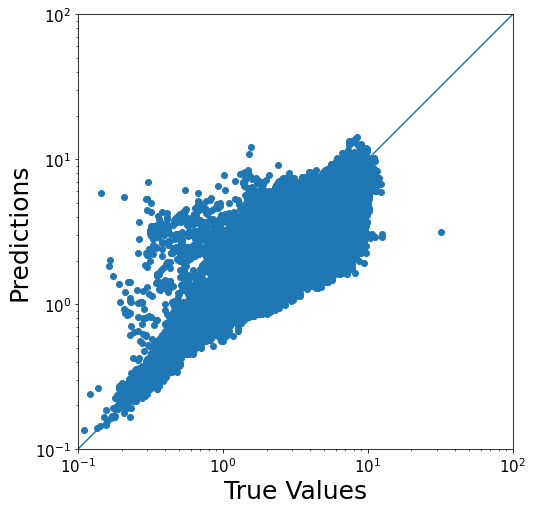

In [86]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-1, 100

a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict1_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

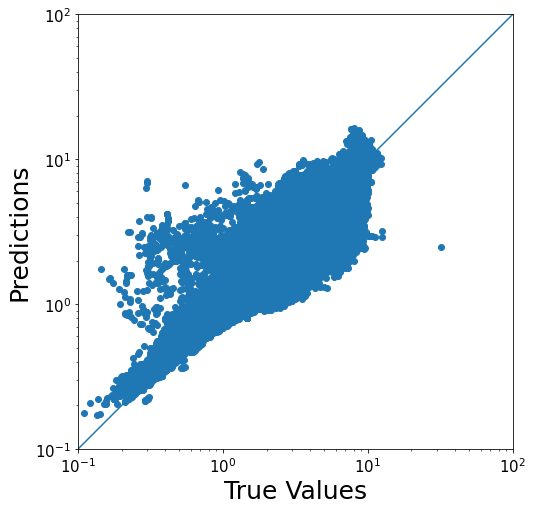

In [87]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict2_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

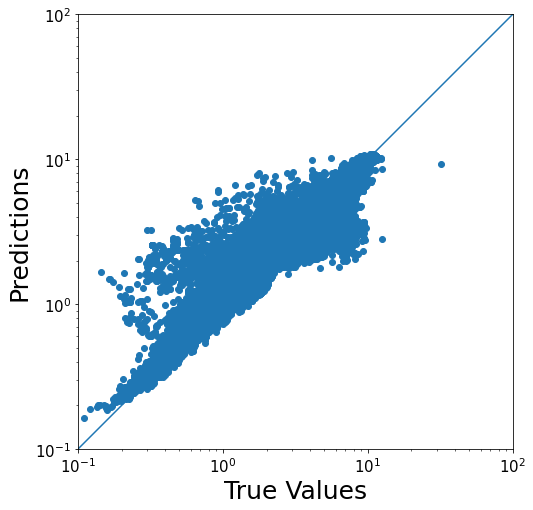

In [88]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict3_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

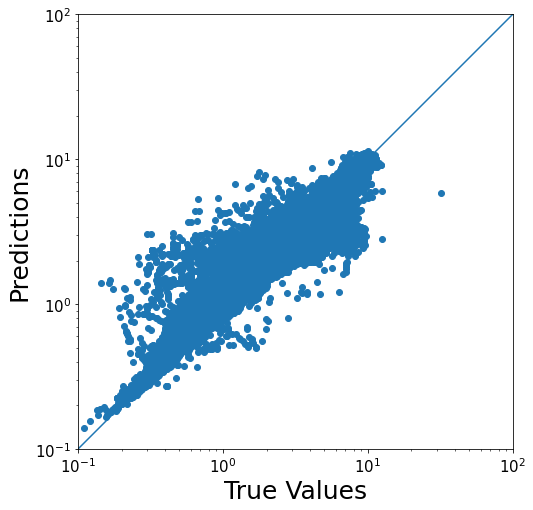

In [89]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict5_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

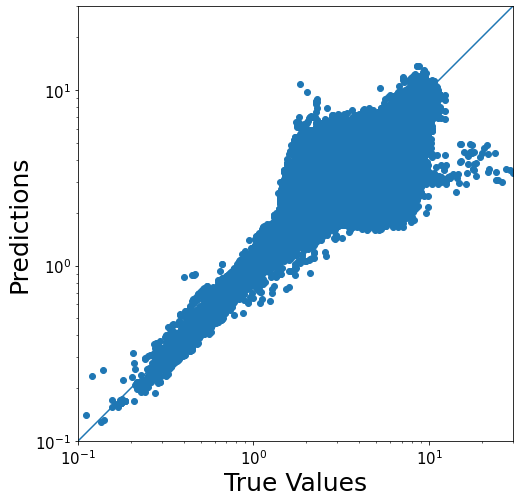

In [90]:
amin, amax = 0.1, 30

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

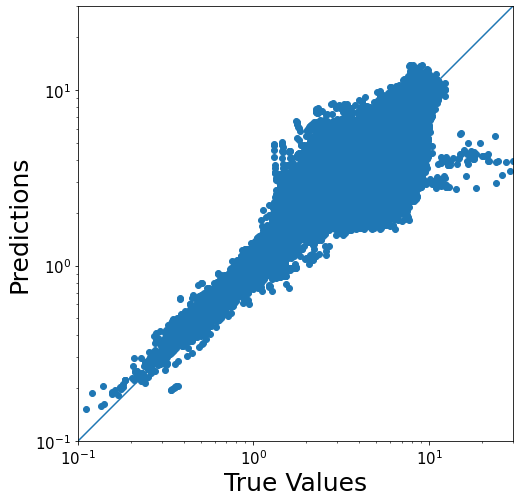

In [91]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict2_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

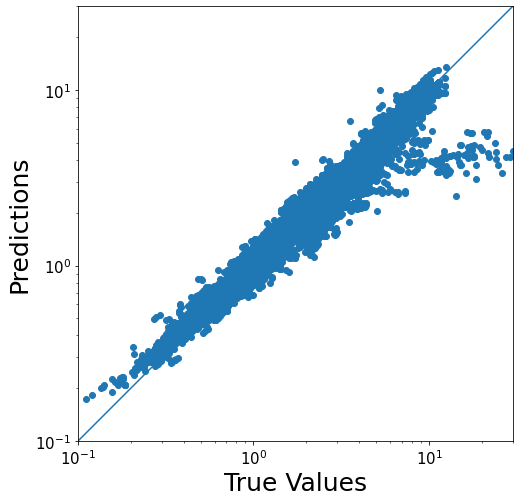

In [92]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict3_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

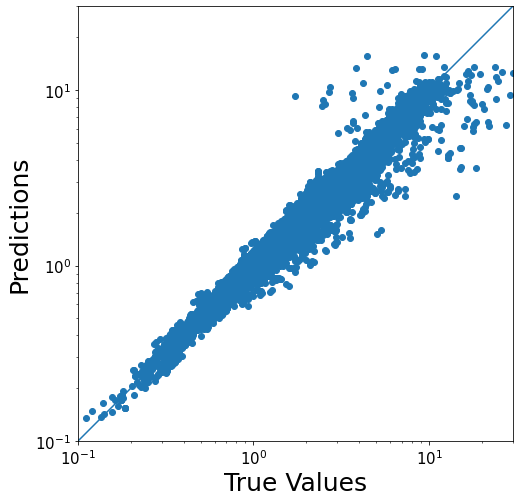

In [93]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict5_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [94]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [95]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [96]:
features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow'
labels   = 'vel_rimesnow_num, vel_rimesnow_mass, vel_rimedsnow_rime, vel_rimedsnow_liq'
filename = 'saved_model_v2/vel_rimedsnow_model1_'+version+'.nc'
logtransform = np.array([True, True, True, True], dtype=bool)
save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,filename)

features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, rho'
logtransform = np.array([True, True, True, True, False], dtype=bool)
save2netcdf(model2,features,labels,train_stats2,train_labels_stats,logtransform,'saved_model_v2/vel_rimedsnow_model2_'+version+'.nc')
save2netcdf(model4,features,labels,train_stats2,train_labels_stats,logtransform,'saved_model_v2/vel_rimedsnow_model4_'+version+'.nc')
save2netcdf(model6,features,labels,train_stats2,train_labels_stats,logtransform,'saved_model_v2/vel_rimedsnow_model6_'+version+'.nc')

features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac_rimedsnow, rho'
logtransform = np.array([True, True, True, True, False, False], dtype=bool)
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_rimedsnow_model3_'+version+'.nc')
save2netcdf(model5,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_rimedsnow_model5_'+version+'.nc')
save2netcdf(model7,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_rimedsnow_model7_'+version+'.nc')

Saving model to saved_model_v2/vel_rimedsnow_model1_13.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow
  Labels:     vel_rimesnow_num, vel_rimesnow_mass, vel_rimedsnow_rime, vel_rimedsnow_liq
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 4), Activation: linear
Saving model to saved_model_v2/vel_rimedsnow_model2_13.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, rho
  Labels:     vel_rimesnow_num, vel_rimesnow_mass, vel_rimedsnow_rime, vel_rimedsnow_liq
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <